In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import Counter

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.layers import SimpleRNN, Embedding, Dense
from keras.models import Sequential
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: CNN_Articels_clean/CNN_Articels_clean.csv  
  inflating: CNN_Articels_clean_2/CNN_Articels_clean.csv  


3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі. Результати порівняйте з одержаними раніш. 

Dataset: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

In [2]:
df = pd.read_csv("/content/CNN_Articels_clean_2/CNN_Articels_clean.csv")
pd.set_option('display.max_columns', None)
proc_df = df.copy()
proc_df.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


In [3]:
Counter( proc_df['Category'])

Counter({'news': 18077,
         'business': 854,
         'health': 557,
         'entertainment': 413,
         'sport': 15542,
         'politics': 2461,
         'travel': 39,
         'vr': 5,
         'style': 1})

In [4]:
proc_df = proc_df[proc_df["Category"].str.contains("news|sport|politics") == True]
proc_df.reset_index(drop=True, inplace=True)
proc_df.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,64,"Ben Morse, CNN",2022-03-21 09:05:42,sport,sport,https://www.cnn.com/2022/03/21/sport/cleveland...,Cleveland Browns defend Deshaun Watson signing...,The Cleveland Browns have defended their signi...,"sport, Cleveland Browns defend Deshaun Watson ...",Cleveland Browns defend Deshaun Watson signing...,(CNN)The Cleveland Browns have defended their...
4,65,"Ben Church, CNN",2022-03-20 18:02:52,sport,motorsport,https://www.cnn.com/2022/03/20/motorsport/bahr...,Bahrain Grand Prix: Ferrari dominates as Charl...,Charles Leclerc won the Bahrain Grand Prix on ...,"motorsport, Bahrain Grand Prix: Ferrari domina...",Bahrain Grand Prix: Ferrari dominates as Charl...,(CNN)Charles Leclerc won the Bahrain Grand Pr...


In [5]:
proc_df['head_desc_head'] = (proc_df["Headline"] + ' ' + proc_df["Description"] + ' ' + proc_df["Second headline"]).str.lower()
proc_df.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text,head_desc_head
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d...","there's a shortage of truckers, but tusimple t..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...,bioservo's robotic 'ironhand' could protect fa...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut...",this swarm of robots gets smarter the more it ...
3,64,"Ben Morse, CNN",2022-03-21 09:05:42,sport,sport,https://www.cnn.com/2022/03/21/sport/cleveland...,Cleveland Browns defend Deshaun Watson signing...,The Cleveland Browns have defended their signi...,"sport, Cleveland Browns defend Deshaun Watson ...",Cleveland Browns defend Deshaun Watson signing...,(CNN)The Cleveland Browns have defended their...,cleveland browns defend deshaun watson signing...
4,65,"Ben Church, CNN",2022-03-20 18:02:52,sport,motorsport,https://www.cnn.com/2022/03/20/motorsport/bahr...,Bahrain Grand Prix: Ferrari dominates as Charl...,Charles Leclerc won the Bahrain Grand Prix on ...,"motorsport, Bahrain Grand Prix: Ferrari domina...",Bahrain Grand Prix: Ferrari dominates as Charl...,(CNN)Charles Leclerc won the Bahrain Grand Pr...,bahrain grand prix: ferrari dominates as charl...


In [6]:
proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('https*\S+', '')
proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('[^A-Za-z]', ' ')
proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('\s{2,}', ' ')

stop_words = stopwords.words("english")
stop_words.append('u')
stop_words.append('cnn')
proc_df['head_desc_head'] = proc_df['head_desc_head'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

<ipython-input-6-f42a0bcb7bc7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('https*\S+', '')
<ipython-input-6-f42a0bcb7bc7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('[^A-Za-z]', ' ')
<ipython-input-6-f42a0bcb7bc7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  proc_df['head_desc_head'] = proc_df['head_desc_head'].str.replace('\s{2,}', ' ')


In [7]:
proc_df.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text,head_desc_head
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d...",shortage truckers tusimple thinks solution dri...
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...,bioservo robotic ironhand could protect factor...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut...",swarm robots gets smarter works hong kong ware...
3,64,"Ben Morse, CNN",2022-03-21 09:05:42,sport,sport,https://www.cnn.com/2022/03/21/sport/cleveland...,Cleveland Browns defend Deshaun Watson signing...,The Cleveland Browns have defended their signi...,"sport, Cleveland Browns defend Deshaun Watson ...",Cleveland Browns defend Deshaun Watson signing...,(CNN)The Cleveland Browns have defended their...,cleveland browns defend deshaun watson signing...
4,65,"Ben Church, CNN",2022-03-20 18:02:52,sport,motorsport,https://www.cnn.com/2022/03/20/motorsport/bahr...,Bahrain Grand Prix: Ferrari dominates as Charl...,Charles Leclerc won the Bahrain Grand Prix on ...,"motorsport, Bahrain Grand Prix: Ferrari domina...",Bahrain Grand Prix: Ferrari dominates as Charl...,(CNN)Charles Leclerc won the Bahrain Grand Pr...,bahrain grand prix ferrari dominates charles l...


In [57]:
texts = []
labels = []
for i, сategory in enumerate(proc_df['Category']):
    texts.append(proc_df['head_desc_head'][i])
    if сategory == 'news':
        labels.append([1., 0., 0.])
    if сategory == 'sport':
        labels.append([0., 1., 0.])
    if сategory == 'politics':
        labels.append([0., 0., 1.])

texts = np.asarray(texts)
labels = np.asarray(labels).astype('float32')


print("number of texts :" , len(texts))
print("number of labels: ", len(labels))

number of texts : 36080
number of labels:  36080


In [58]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

word_index = tokenizer.word_index
num_unique_words = len(tokenizer.word_index) + 1
print(f"Found {len(word_index)} unique words")

print(len(data[0]))

Found 39002 unique words
68


In [59]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

training_set = list(zip(X_train, y_train))
test_set = list(zip(X_test, y_test))

train_loader = DataLoader(training_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [51]:
class SmallPP(nn.ModuleList):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(NUM_WORDS, 32, padding_idx=0)
        self.rnn = nn.RNN(32, 32, 1, batch_first=True)
        self.fc1 = nn.Linear(32, 3)

    def forward(self, x):
        h0 = torch.randn(1, 16, 32).to(device)

        x = self.embedding(x)
        x, _ = self.rnn(x, h0)

        x = self.fc1(x[:,-1,:])

        return x

In [54]:
model = SmallPP().to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epoch in range(epochs):
    running_loss = 0
    
    for texts, labels in tqdm(train_loader):
        
        texts = texts.type(torch.LongTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        output = model(texts)

        loss = criterion(output, labels)
        losses.append(loss)
        running_loss += loss
        
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}; Loss {running_loss}")

100%|██████████| 1804/1804 [00:06<00:00, 291.95it/s]


Epoch 1; Loss 1147.4786376953125


100%|██████████| 1804/1804 [00:05<00:00, 332.41it/s]


Epoch 2; Loss 650.1751098632812


100%|██████████| 1804/1804 [00:07<00:00, 233.40it/s]


Epoch 3; Loss 463.3675537109375


100%|██████████| 1804/1804 [00:05<00:00, 332.51it/s]


Epoch 4; Loss 367.4456787109375


100%|██████████| 1804/1804 [00:05<00:00, 357.51it/s]


Epoch 5; Loss 384.7378234863281


100%|██████████| 1804/1804 [00:05<00:00, 360.77it/s]


Epoch 6; Loss 320.00396728515625


100%|██████████| 1804/1804 [00:05<00:00, 358.86it/s]


Epoch 7; Loss 202.9052276611328


100%|██████████| 1804/1804 [00:05<00:00, 356.73it/s]


Epoch 8; Loss 173.30616760253906


100%|██████████| 1804/1804 [00:05<00:00, 359.29it/s]


Epoch 9; Loss 127.8738021850586


100%|██████████| 1804/1804 [00:05<00:00, 360.24it/s]

Epoch 10; Loss 176.29803466796875


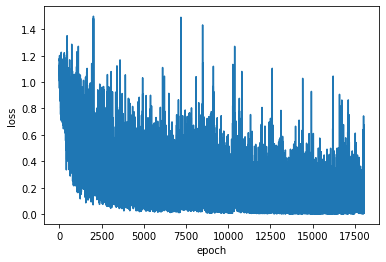

0.8646064400672913


In [66]:
l = []
for loss in losses:
    l.append(loss.cpu().detach().numpy())

plt.plot(l)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

accuracy = []
preds = []
for texts, labels in test_loader:
    output = model(texts.to(device))
    _, pred = torch.max(output, 1)
    _, test = torch.max(labels, 1)
    preds.append(pred)
    accuracy.append(torch.sum(pred.cpu() == test)/len(test))

print((sum(accuracy)/len(accuracy)).item())

In [ ]:
preds